# Segment Anything Model using `transformers` 🤗 library


| <img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/model_doc/sam-beancans.png" alt="Snow" width="300" height="300"> | <img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/model_doc/sam-dog-masks.png" alt="Forest" width="300" height="300"> | <img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/model_doc/sam-car-seg.png" alt="Mountains" width="300" height="300"> |
|---------------------------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------|


This notebook demonstrates how to use the Segment Anything Model (SAM) to segment objects in images. The model has been released by Meta AI in the paper [Segment Anything Model](https://ai.facebook.com/research/publications/segment-anything/). The original source code can be found [here](https://github.com/facebookresearch/segment-anything)

This notebook demonstrates how to use `transformers` to leverage the different usecases of the model. The examples are heavily inspired from the [original notebook of the authors](https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb).

As stated by that notebook: 
> The Segment Anything Model (SAM) predicts object masks given prompts that indicate the desired object. The model first converts the image into an image embedding that allows high quality masks to be efficiently produced from a prompt.

In [ ]:
!pip install -q transformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 81.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 27.2 MB/s eta 0:00:00


## Utility functions

Run the cells below to import the needed utility functions for displaying the masks!

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

def show_boxes_on_image(raw_image, boxes):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_on_image(raw_image, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_masks_on_image(raw_image, masks, scores):
    if len(masks.shape) == 4:
      masks = masks.squeeze()
    if scores.shape[0] == 1:
      scores = scores.squeeze()

    nb_predictions = scores.shape[-1]
    fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))

    for i, (mask, score) in enumerate(zip(masks, scores)):
      mask = mask.cpu().detach()
      axes[i].imshow(np.array(raw_image))
      show_mask(mask, axes[i])
      axes[i].title.set_text(f"Mask {i+1}, Score: {score.item():.3f}")
      axes[i].axis("off")
    plt.show()

## Model loading

Use the `from_pretrained` method on the `SamForMaskGeneration` class to load the model from the Hub! For the sake of this demonstration we will use the `vit-huge` checkpoint.

In [24]:
import torch
from transformers import SamModel, SamProcessor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

## Run predictions

Let's deeply dive into how you can run different type of predictions, given different inputs. You will see how to

- Generate segmentation masks given a 2D localization
- Generate segmentation masks per given localization (one prediction per 2D point)
- Generate segmentation masks given a bounding box
- Generate segmentation masks given a bounding box and a 2D points
- Generate segmentat

### Load the example image

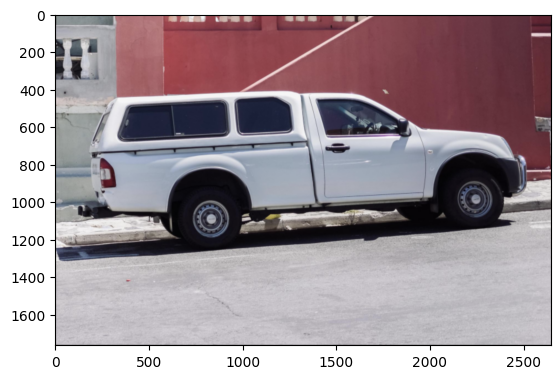

In [25]:
from PIL import Image
import requests

img_url = "https://huggingface.co/ybelkada/segment-anything/resolve/main/assets/car.png"
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")

plt.imshow(raw_image)

In [26]:
#raw_image = Image.open('examples/test_image.png')

## Step 1: Retrieve the image embeddings

In order to avoid computing multiple times the same image embeddings, we will compute it only once, and use these embeddings to directly feed them to the model for faster inference

In [27]:
inputs = processor(raw_image, return_tensors="pt").to(device)
image_embeddings = model.get_image_embeddings(inputs["pixel_values"])

## Usecase 1: Feed a set of 2D points to predict a mask

Let's first focus on the first classic usecase of SAM. You can feed the model a set of 2D points to predict a segmentation mask. The more you provide 2D points, the better the resulting mask will be. 

In this example, let's try to predict the mask that corresponds to the top left window of the parked car.

The input points needs to be in the format:

`nb_images, nb_predictions, nb_points_per_mask, 2`

With SAM you can either predict a single prediction given multiple points, or a prediction per point. This is denoted by `nb_predictions` dimension. We will see in the next sections how to perform this type of prediction

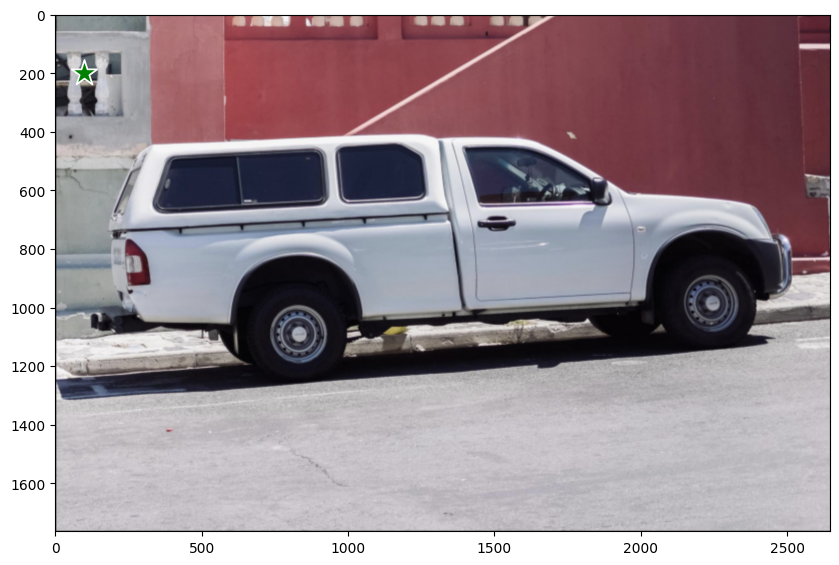

In [28]:
input_points = [[[100, 200]]]
show_points_on_image(raw_image, input_points[0])

For that, simply pass the raw image, the points




In [29]:
inputs = processor(raw_image, input_points=input_points, return_tensors="pt").to(device)
# pop the pixel_values as they are not neded
inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})

with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

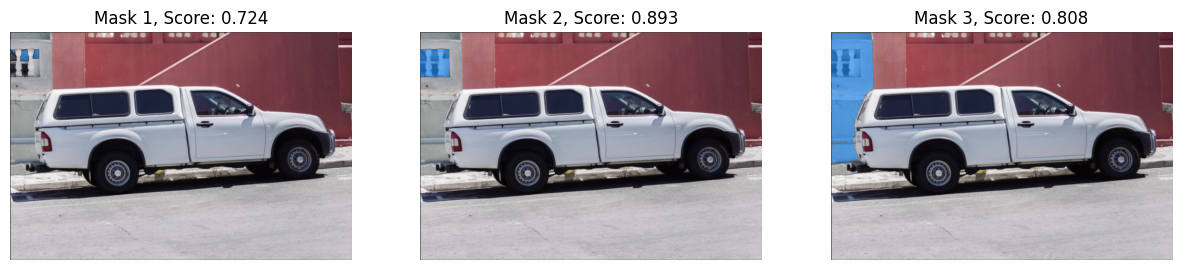

In [30]:
show_masks_on_image(raw_image, masks[0], scores)

In [31]:
print(masks[0][0])
mask_ = masks[0][0][2].numpy().astype(np.uint8)*128
print(np.max(mask_))
mask_ = Image.fromarray(mask_)
mask_.save('examples/mask.png')

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [

As you can see, the predicted masks are sorted in their IoU score order. The first mask indeed seems to correspond to the mask of the top right window of the parked car.

You can also feed a set of points to predict a single mask. Let's try to predict a mask, given two points

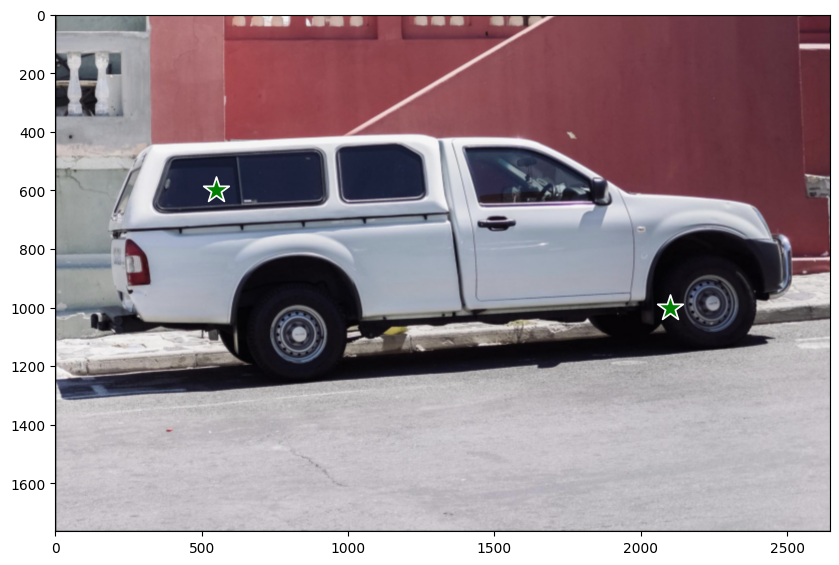

In [32]:
input_points = [[[550, 600], [2100, 1000]]]
show_points_on_image(raw_image, input_points)

In [33]:
inputs = processor(raw_image, input_points=input_points, return_tensors="pt").to(device)
# pop the pixel_values as they are not neded
inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})

with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

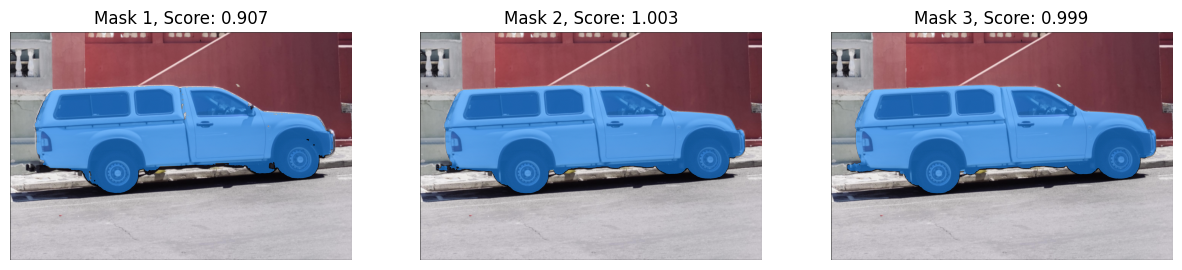

In [34]:
show_masks_on_image(raw_image, masks[0], scores)

## Usecase 2: Predict segmentations masks using bounding boxes

It is possible to feed bounding boxes to the model to predict segmentation masks of the object of interest in that region.

The bounding box needs to be a list of points, corresponding to the flattened coordinates of the top left point, and bottom right point of the bounding box. Let's look at an example below

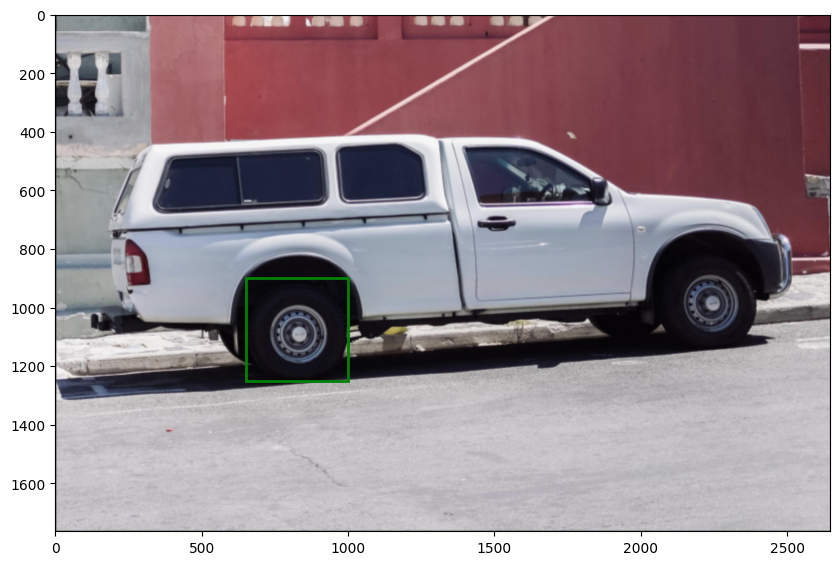

In [35]:
input_boxes = [[[650, 900, 1000, 1250]]]

show_boxes_on_image(raw_image, input_boxes[0]) 

We will try to segment the wheel that is present inside the bounding box! For that just run the following snippet

In [36]:
inputs = processor(raw_image, input_boxes=[input_boxes], return_tensors="pt").to(device)
inputs["input_boxes"].shape

torch.Size([1, 1, 4])

In [37]:
inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})

with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

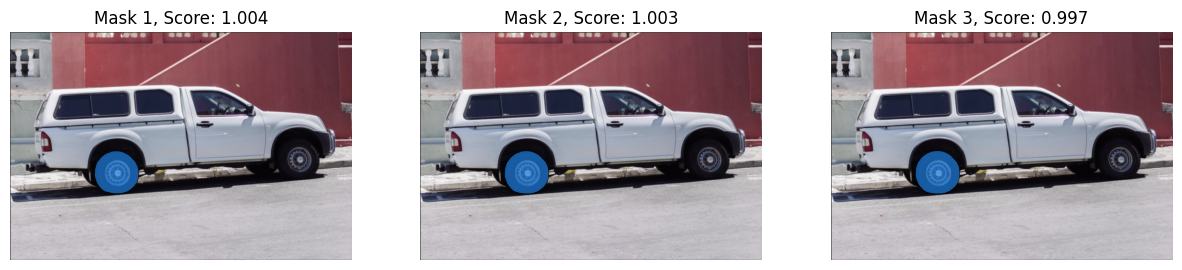

In [38]:
show_masks_on_image(raw_image, masks[0], scores)

It is possible to feed multiple boxes, however, this will lead to having one prediction per bounding box. i.e., you cannot combine multiple bounding boxes to get a single prediction. However, you can combine points and bounding boxes to get a prediction, and we will cover that in the next section

## Usecase 3: Predict segmentation masks given points and bounding boxes

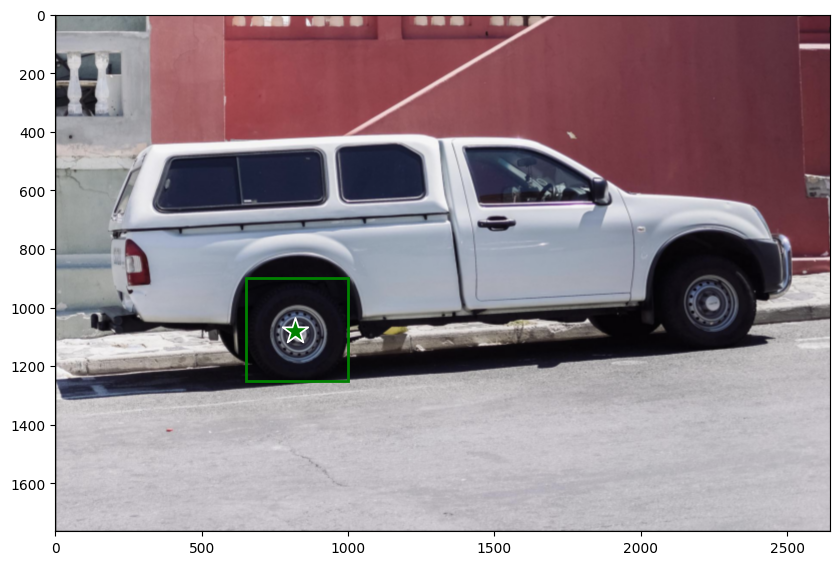

In [39]:
input_boxes = [[[650, 900, 1000, 1250]]]
input_points = [[[820, 1080]]]

show_points_and_boxes_on_image(raw_image, input_boxes[0], input_points[0])

In [40]:
inputs = processor(raw_image, input_boxes=[input_boxes], input_points=[input_points], return_tensors="pt").to(device)

inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})

with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

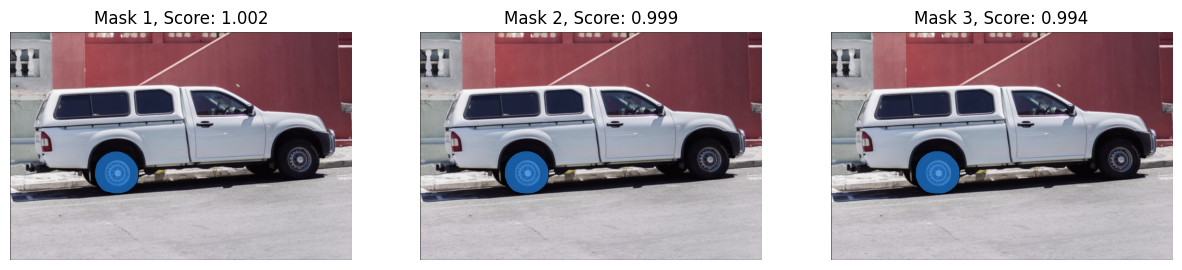

In [41]:
show_masks_on_image(raw_image, masks[0][0], scores[:, 0, :])

You can also pass points with a label to segment out that region. Let us have a deeper look below

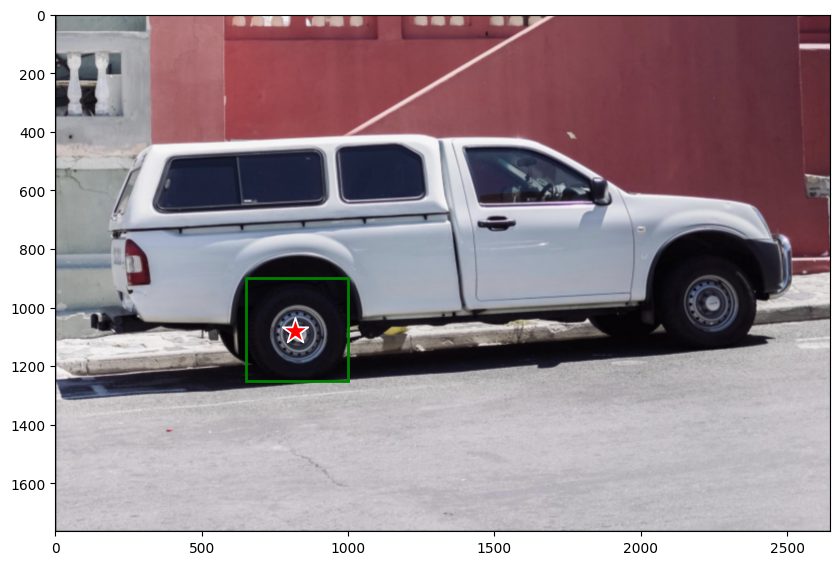

In [42]:
input_boxes = [[[650, 900, 1000, 1250]]]
input_points = [[[820, 1080]]]
labels = [0]

show_points_and_boxes_on_image(raw_image, input_boxes[0], input_points[0], labels)

In [43]:
input_boxes = [[[620, 900, 1000, 1255]]]
input_points = [[[820, 1080]]]
labels = [[0]]
inputs = processor(raw_image, input_boxes=[input_boxes], input_points=[input_points], input_labels=[labels], return_tensors="pt").to(device)

inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})

with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

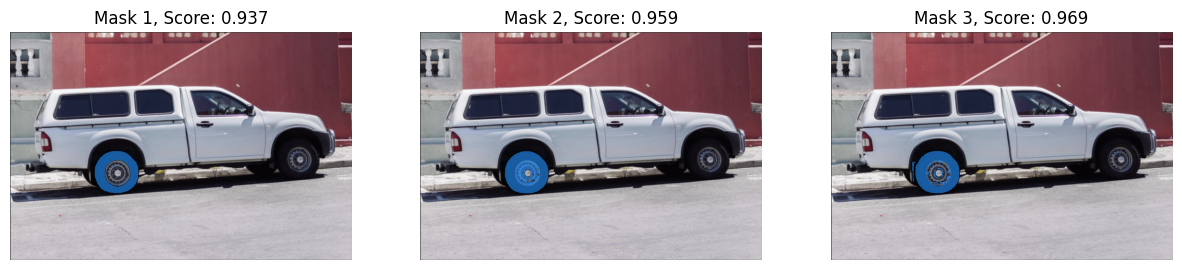

In [44]:
show_masks_on_image(raw_image, masks[0][0], scores[:, 0, :])

As you can see, the model managed to "ignore" the component that was specified by the point with the label `0`.

## Usecase 4: Predict multiple masks per image

With SAM, you can also predict multiple masks per image. You can achieve that in two possible scenarios

- Feed multiple points in the `nb_predictions` dimension
- Feed multiple bounding boxes to the same image

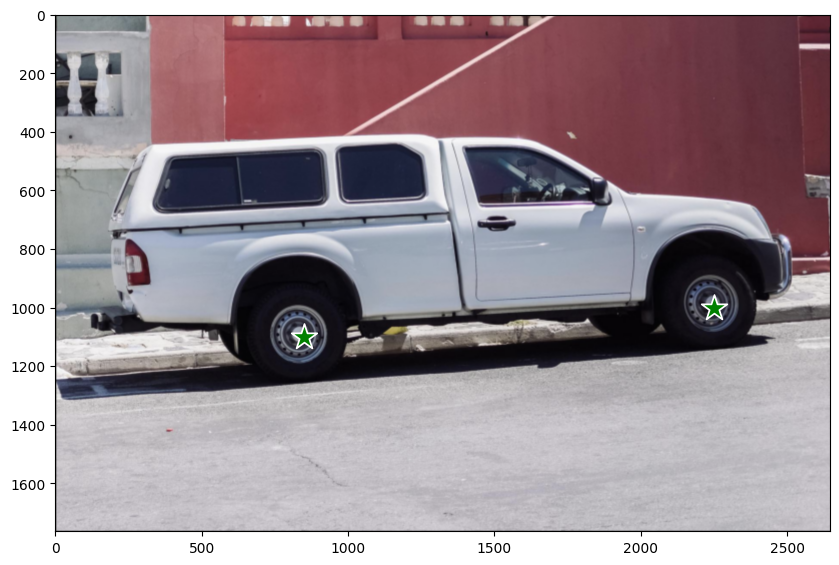

In [45]:
input_points = [[[850, 1100], [2250, 1000]]]
show_points_on_image(raw_image, input_points)

### Sub-usecase 1: one prediction per point

To benefit from what we have described in the first bullet point, just change the input array to

In [46]:
input_points = [[[850, 1100]], [[2250, 1000]]]

In order to add the desired dimension, and pass it to the `SamProcessor`

In [47]:
input_points = [[[[850, 1100]], [[2250, 1000]]]]
inputs = processor(raw_image, input_points=input_points, return_tensors="pt").to(device)
inputs["input_points"].shape

torch.Size([1, 2, 1, 2])

In [48]:
inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})

with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

Let's print the shapes of the output to understand better what is going on

In [49]:
scores.shape

torch.Size([1, 2, 3])

Here the first dimension corresponds to the image batch size, the second dimension corresponds to the `nb_predictions` dimension. And the last dimension is the number of predicted masks **per prediction** , and it is set to 3 by default according to the official implementation

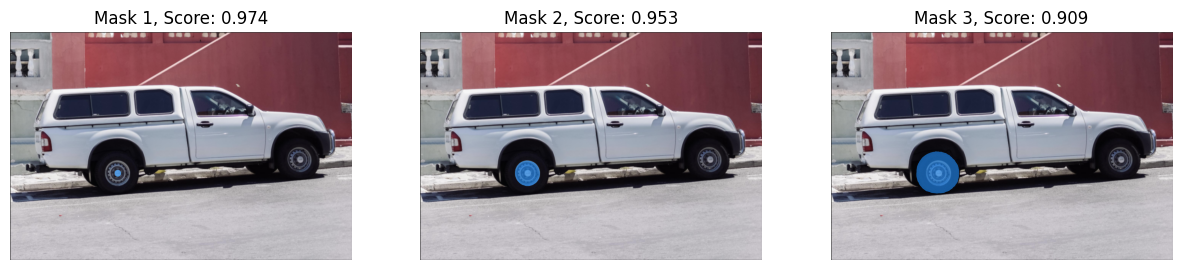

In [50]:
show_masks_on_image(raw_image, masks[0][0], scores[:, 0, :])

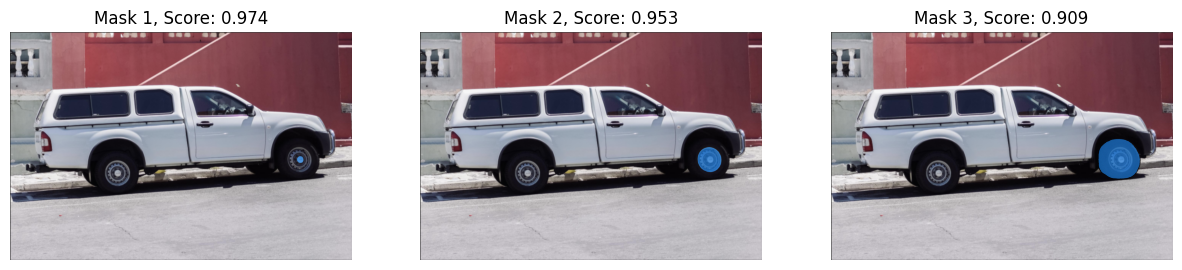

In [51]:
show_masks_on_image(raw_image, masks[0][1], scores[:, 0, :])

### Sub-usecase 2: Feed multiple bounding boxes to the same image

You can also feed multiple bounding boxes to the same image and get one prediction per bounding box. 

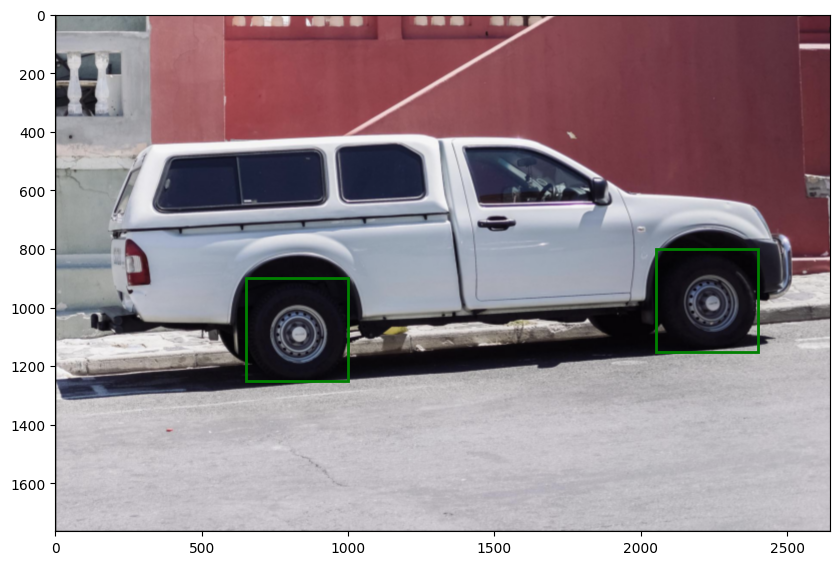

In [52]:
input_boxes = [[[650, 900, 1000, 1250], [2050, 800, 2400, 1150]]]

show_boxes_on_image(raw_image, input_boxes[0]) 

Just pass the input boxes as follows, to match the convention of the processor

In [53]:
input_boxes = [[[650, 900, 1000, 1250], [2050, 800, 2400, 1150]]]
inputs = processor(raw_image, input_boxes=input_boxes, return_tensors="pt").to(device)
inputs["input_boxes"].shape

torch.Size([1, 2, 4])

This time, let's just output a single mask per box, for that we can just pass `multimask_output=False` in the forward pass

In [54]:
inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})

with torch.no_grad():
    outputs = model(**inputs, multimask_output=False)

masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

In [55]:
scores.shape

torch.Size([1, 2, 1])

As you can see, here we have predicted 2 masks in total! Let's check them now

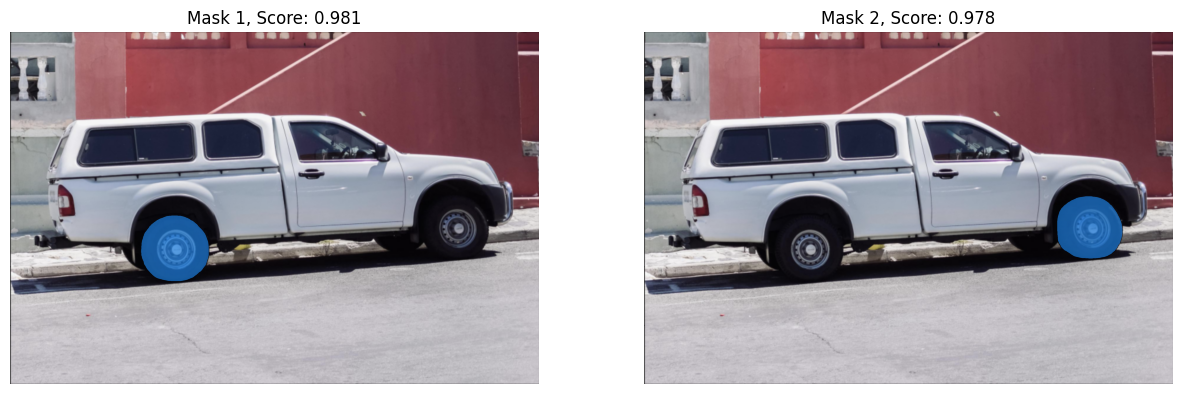

In [56]:
show_masks_on_image(raw_image, masks[0], scores)